In [29]:
import mne
import numpy as np
import pandas as pd
from scipy.signal import coherence, hilbert
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# ====== CONFIGURACIÓN ======
edf_path = r"C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target = 256            # Frecuencia de muestreo a la que normalizamos (Hz)
fmin, fmax = 8, 13            # Banda alfa para la coherencia (puedes ajustar)

In [19]:
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1., 45., fir_design='firwin')
data = raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\monce\OneDrive\Documentos\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\monce\AppData\Local\Temp\ipykernel_34340\1857893954.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [15]:
data

array([[-6.26804381e-20,  9.96691423e-05,  1.56464544e-04, ...,
        -3.25461886e-05, -2.44063872e-05, -3.38813179e-21],
       [ 0.00000000e+00,  7.14210275e-05,  1.12391959e-04, ...,
        -5.47231902e-06, -1.78326784e-06, -1.10114283e-20],
       [-8.47032947e-21,  3.00249387e-05,  4.62387169e-05, ...,
         1.76838641e-05,  1.13131737e-05, -8.47032947e-22],
       ...,
       [-5.08219768e-20,  1.84483340e-04,  2.87170890e-04, ...,
         3.62255574e-05,  1.60453355e-05,  5.08219768e-21],
       [-1.10114283e-20, -6.40667792e-05, -1.01071351e-04, ...,
         7.34684870e-06,  1.44976840e-06, -1.27054942e-21],
       [ 1.86347248e-20, -3.08754614e-05, -4.79904833e-05, ...,
        -8.25147645e-06, -5.29050421e-06,  1.16467030e-21]],
      shape=(23, 921600))

In [21]:
ch_names


23

In [22]:
n_channels

23

In [23]:
# ====== 1. MATRIZ DE CORRELACIÓN DE PEARSON ======
corr_matrix = np.corrcoef(data)
corr_df = pd.DataFrame(corr_matrix, index=ch_names, columns=ch_names)
corr_df.to_csv("connectivity_pearson.csv")

# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
coh_df.to_csv("connectivity_coherence.csv")

# ====== 3. MATRIZ DE PHASE LOCKING VALUE (PLV) ======
analytic_signal = hilbert(data)
phase_data = np.angle(analytic_signal)

plv_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        phase_diff = phase_data[i] - phase_data[j]
        plv_matrix[i, j] = np.abs(np.sum(np.exp(1j * phase_diff)) / phase_diff.size)

plv_df = pd.DataFrame(plv_matrix, index=ch_names, columns=ch_names)
plv_df.to_csv("connectivity_plv.csv")

print("✅ Matrices de conectividad generadas:")
print("- connectivity_pearson.csv")
print("- connectivity_coherence.csv")
print("- connectivity_plv.csv")

✅ Matrices de conectividad generadas:
- connectivity_pearson.csv
- connectivity_coherence.csv
- connectivity_plv.csv


In [26]:
plv_df.head

<bound method NDFrame.head of             FP1-F7     F7-T7     T7-P7     P7-O1    FP1-F3     F3-C3  \
FP1-F7    1.000000  0.074626  0.055968  0.060709  0.624161  0.173790   
F7-T7     0.074626  1.000000  0.164502  0.034743  0.296048  0.428383   
T7-P7     0.055968  0.164502  1.000000  0.200252  0.095674  0.290597   
P7-O1     0.060709  0.034743  0.200252  1.000000  0.028683  0.041287   
FP1-F3    0.624161  0.296048  0.095674  0.028683  1.000000  0.116789   
F3-C3     0.173790  0.428383  0.290597  0.041287  0.116789  1.000000   
C3-P3     0.049846  0.312913  0.439663  0.335772  0.012603  0.277841   
P3-O1     0.009869  0.085794  0.271496  0.500766  0.044645  0.076763   
FP2-F4    0.367289  0.228681  0.101994  0.044863  0.512120  0.186785   
F4-C4     0.181558  0.197666  0.182175  0.139657  0.128609  0.386850   
C4-P4     0.186693  0.171789  0.207004  0.159101  0.090305  0.366742   
P4-O2     0.078866  0.075657  0.186261  0.422735  0.009080  0.055297   
FP2-F8    0.376677  0.279580  0.08

In [ ]:
#Actividades de clase
Generar el mapa de calor de cada matriz de conectividad
Generar la distribución de datos de cada matriz de conectividad
¿Qué valor se encuentra en el percentil 0.75 de cada matriz de conectividad
Genera el grafo 2D de cada matriz de conectividad y compararlos
Generar el grado 3D de cada matriz de conectividad y compararlos

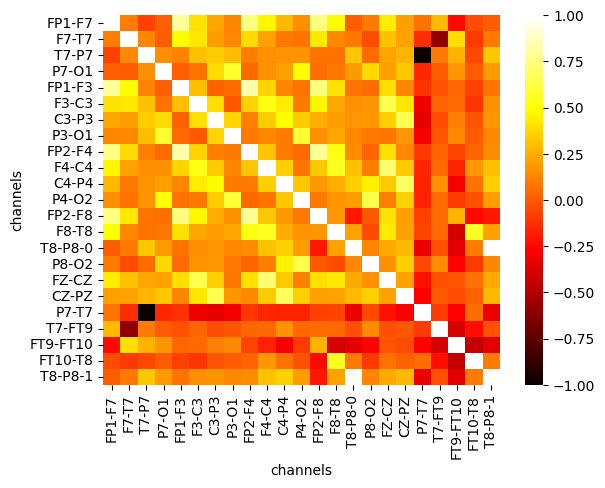

In [31]:
ax= sns.heatmap(corr_df.values,
                annot= False, cmap ="hot", fmt=".2f",
                xticklabels=corr_df.columns, yticklabels= corr_df.index)
ax.set(xlabel="channels", ylabel="channels")
plt.show()

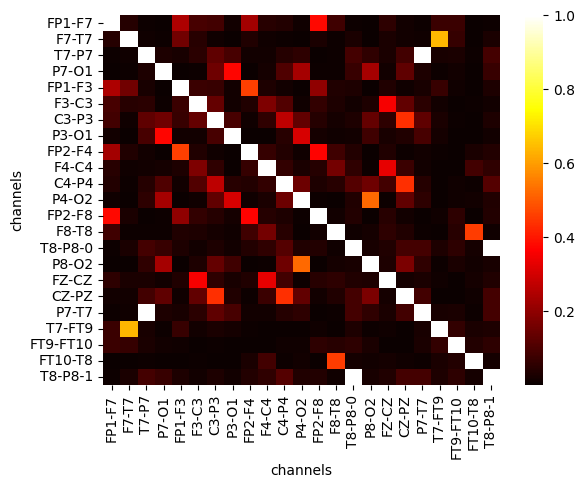

In [32]:
ax= sns.heatmap(coh_df.values,
                annot= False, cmap ="hot", fmt=".2f",
                xticklabels=coh_df.columns, yticklabels= coh_df.index)
ax.set(xlabel="channels", ylabel="channels")
plt.show()

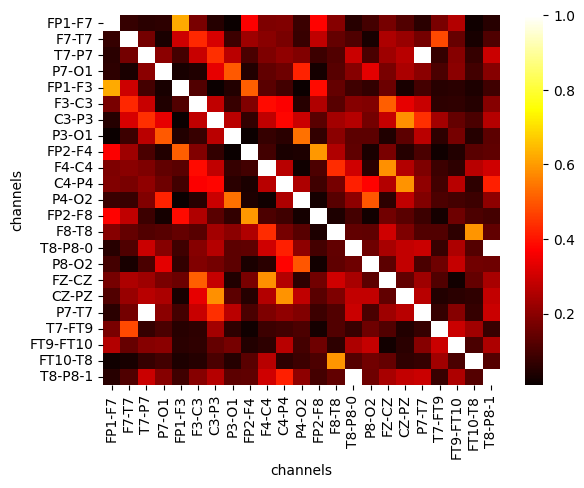

In [33]:
ax= sns.heatmap(plv_df.values,
                annot= False, cmap ="hot", fmt=".2f",
                xticklabels=plv_df.columns, yticklabels= plv_df.index)
ax.set(xlabel="channels", ylabel="channels")
plt.show()

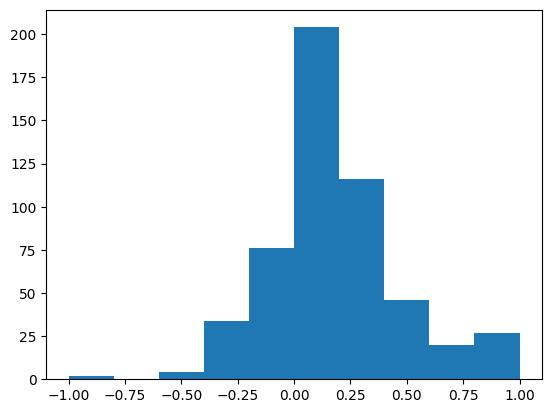

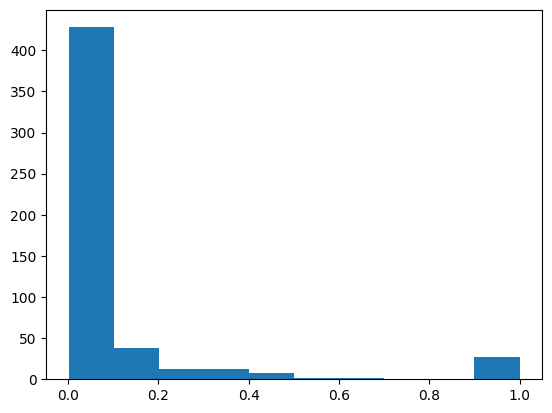

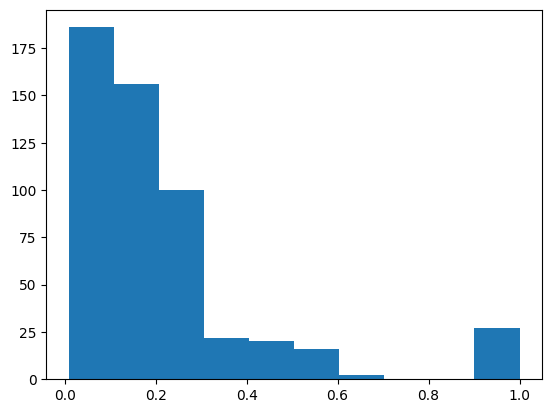

In [45]:
#Generar la distribución de datos de cada matriz de conectividalista=[]
#corr_df
b=corr_df.values.flatten();
hist=plt.hist(b)
plt.show(hist)
#2 coh_df
c=coh_df.values.flatten();
hist=plt.hist(c)
plt.show(hist)
#3 plv_df
d=plv_df.values.flatten();
hist=plt.hist(d)
plt.show(hist)

In [54]:
np.percentile(b, 75)
np.percentile(c, 75)
np.percentile(d, 75)
print(f"Los datos debajo del percentil 75 en cada matriz son: {np.percentile(b, 75)},{np.percentile(c, 75)},{np.percentile(d, 75)}")

Los datos debajo del percentil 75 en cada matriz son: 0.32938086580951453,0.08287163514424088,0.27149641427473087


AttributeError: 'DataFrame' object has no attribute 'is_directed'

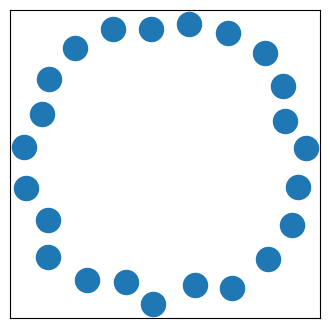

In [56]:
import networkx as nx

plt.figure(figsize=(4,4))
nx.draw_networkx(corr_df) ##pos permite indicar las coordanas que establecimos.
plt.show() 